In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from load_data import process_steel_data

full_path = 'data/'
path = 'data/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
correlation_rate = 0.2
dvl_line = 1

df = process_steel_data(full_path, path, correlation_rate, dvl_line, model_output=True)

Dropped 24 columns


/opt/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
# labeling the features for each branch
features = [col for col in df.columns if col not in ['r_value', 'steel_family']]
features_dict = {
   'time': [col for col in features if 'time' in col.lower()], 
   'chemical': ['pct_al', 'pct_b', 'pct_c', 'pct_cr', 'pct_mn', 'pct_n', 'pct_nb', 'pct_si', 'pct_ti', 'pct_v', 'mfia_coil_frac_fer', 'mfia_et1_frac_fer', 'mfia_et2_frac_fer'],
   'model': ["rm", "ag", "a80", "n_value"]
}
features_dict['process'] = [col for col in features if col not in features_dict['time'] and col not in features_dict['chemical']]

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split first to avoid data leakage
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Scale the training set
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(['steel_family', 'steel_grade'], axis=1))
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
train_scaled_df['steel_family'] = train_df['steel_family'].reset_index(drop=True)

# Scale the testing set using the scaler fitted on the training set
test_scaled = scaler.transform(test_df.drop(['steel_family', 'steel_grade'], axis=1))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
test_scaled_df['steel_family'] = test_df['steel_family'].reset_index(drop=True)

In [5]:
class MultiBranchSteelRegressor(nn.Module):
    def __init__(self,
                 chemical_dim, time_dim, process_dim, model_dim,
                 base_hidden_units=64, branch_hidden_units=64,
                 base_dropout_rate=0.2, branch_dropout_rate=0.2,
                 final_hidden_units=[128, 64], final_dropout_rate=0.2):
        super().__init__()
        # Track which branches are active
        self.has_chemical = chemical_dim > 0
        self.has_time = time_dim > 0
        self.has_process = process_dim > 0
        self.has_model = model_dim > 0
        # Count active branches
        self.active_branches = sum([self.has_chemical, self.has_time, self.has_process, self.has_model])
        
        # Common base layer
        self.base_hidden_units = base_hidden_units
        self.common_base_layer = nn.Sequential(
            nn.Linear(chemical_dim + time_dim + process_dim + model_dim, self.base_hidden_units),
            nn.BatchNorm1d(self.base_hidden_units),
            nn.ReLU(),
            nn.Dropout(base_dropout_rate)
        )
        
        # Branch hidden units and dropout rates
        self.branch_hidden_units = branch_hidden_units
        
        # Creating branch
        def create_branch(input_dim):
            return nn.Sequential(
                nn.Linear(input_dim, self.branch_hidden_units),
                nn.BatchNorm1d(self.branch_hidden_units),
                nn.ReLU(),
                nn.Dropout(branch_dropout_rate)
            )
        
        # Only create branches that have features
        if self.has_chemical:
            self.chemical_branch = create_branch(self.base_hidden_units)
        if self.has_time:
            self.time_branch = create_branch(self.base_hidden_units)
        if self.has_process:
            self.process_branch = create_branch(self.base_hidden_units)
        if self.has_model:
            self.model_branch = create_branch(self.base_hidden_units)
        
        # Combined input dimension based on active branches only
        combined_dim = self.branch_hidden_units * self.active_branches
        
        # Final layers after concatenation
        final_layers = []
        input_dim = combined_dim
        for units in final_hidden_units:
            final_layers.append(nn.Linear(input_dim, units))
            final_layers.append(nn.BatchNorm1d(units))
            final_layers.append(nn.ReLU())
            final_layers.append(nn.Dropout(final_dropout_rate))
            input_dim = units
        final_layers.append(nn.Linear(input_dim, 1))  # Output layer
        self.final_layers = nn.Sequential(*final_layers)

    def forward(self, chemical, time, process, model):
        features = []
        # Concatenate all input features for the common base layer
        inputs = []
        if self.has_chemical:
            inputs.append(chemical)
        if self.has_time:
            inputs.append(time)
        if self.has_process:
            inputs.append(process)
        if self.has_model:
            inputs.append(model)
        inputs = torch.cat(inputs, dim=1)  # Concatenate all inputs
        base_features = self.common_base_layer(inputs)  # Pass through the common base layer

        # Split base features into branches
        if self.has_chemical:
            features.append(self.chemical_branch(base_features))
        if self.has_time:
            features.append(self.time_branch(base_features))
        if self.has_process:
            features.append(self.process_branch(base_features))
        if self.has_model:
            features.append(self.model_branch(base_features))

        # Concatenate only active features
        combined = torch.cat(features, dim=1) if len(features) > 1 else features[0]
        return self.final_layers(combined)

In [6]:
def train_family_models(df, features_dict, num_epochs, hyperparameters, use_l2=False):
    family_models = {}
    evaluation_results = {}
    batch_size = hyperparameters['batch_size']

    for family in df['steel_family'].unique():
        family_data = df[df['steel_family'] == family].drop(['steel_family'], axis=1)

        # Initialize feature arrays and dimensions
        feature_arrays = {}
        feature_dims = {}

        # Process each feature category
        for category in ['chemical', 'time', 'process', 'model']:
            available_features = [col for col in features_dict[category] 
                                if col in family_data.columns]

            if available_features:
                # Scale each feature category independently
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
                feature_dims[category] = len(available_features)
            else:
                feature_arrays[category] = np.zeros((len(family_data), 0))  # Empty array
                feature_dims[category] = 0

        # Prepare targets
        targets = family_data['r_value'].values

        # Split data
        split_data = train_test_split(
            feature_arrays['chemical'],
            feature_arrays['time'],
            feature_arrays['process'],
            feature_arrays['model'],
            targets,
            test_size=0.2,
            random_state=42
        )

        (X_train_chem, X_test_chem, X_train_time, X_test_time, 
         X_train_proc, X_test_proc, X_train_model, X_test_model, 
         y_train, y_test) = split_data

        # Convert to tensors
        train_tensors = {
            'chemical': torch.FloatTensor(X_train_chem),
            'time': torch.FloatTensor(X_train_time),
            'process': torch.FloatTensor(X_train_proc),
            'model': torch.FloatTensor(X_train_model)
        }

        test_tensors = {
            'chemical': torch.FloatTensor(X_test_chem),
            'time': torch.FloatTensor(X_test_time),
            'process': torch.FloatTensor(X_test_proc),
            'model': torch.FloatTensor(X_test_model)
        }

        y_train_tensor = torch.FloatTensor(y_train)
        y_test_tensor = torch.FloatTensor(y_test)

        # Create DataLoader
        train_dataset = TensorDataset(
            train_tensors['chemical'],
            train_tensors['time'],
            train_tensors['process'],
            train_tensors['model'],
            y_train_tensor
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        # Initialize model
        model = MultiBranchSteelRegressor(
            chemical_dim=feature_dims['chemical'],
            time_dim=feature_dims['time'],
            process_dim=feature_dims['process'],
            model_dim=feature_dims['model'],
            base_hidden_units=hyperparameters['base_hidden_units'],
            branch_hidden_units=hyperparameters['branch_hidden_units'],
            base_dropout_rate=hyperparameters['base_dropout_rate'],
            branch_dropout_rate=hyperparameters['branch_dropout_rate'],
            final_hidden_units=hyperparameters['final_hidden_units'],
            final_dropout_rate=hyperparameters['final_dropout_rate']
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])
        criterion = nn.L1Loss()

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for batch_chem, batch_time, batch_proc, batch_model, batch_targets in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_chem, batch_time, batch_proc, batch_model)
                loss = criterion(outputs, batch_targets.unsqueeze(1))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred = model(
                test_tensors['chemical'],
                test_tensors['time'],
                test_tensors['process'],
                test_tensors['model']
            )
            test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1)).item()
            y_pred_np = y_pred.numpy().flatten()
            r2 = r2_score(y_test, y_pred_np)
            mae = mean_absolute_error(y_test, y_pred_np)

            evaluation_results[family] = {
                'test_loss': test_loss,
                'r2_score': r2,
                'Mean Absolute Error': mae
            }
            print(f"Evaluation for {family} - Test Loss: {test_loss:.4f}, R2: {r2:.4f}")

        family_models[family] = model

    return family_models, evaluation_results

In [7]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [1e-3],
    'batch_size': [32, 64, 128],
    'base_hidden_units': [64, 128],
    'branch_hidden_units': [32, 64],
    'base_dropout_rate': [0, 0.2],
    'branch_dropout_rate': [0, 0.2],
    'final_hidden_units': [[128, 64], [256, 128]],
    'final_dropout_rate': [0, 0.2]
}
grid = ParameterGrid(param_grid)

In [8]:
# from tqdm import tqdm

# num_epochs = 50

# best_results = {}
# best_params = None

# for params in tqdm(grid, desc="Grid Search Progress", leave=True):
#     print(f"\nEvaluating hyperparameters: {params}")
    
#     family_models, evaluation_results = train_family_models(dvl1_scaled_df, features_dict, num_epochs, params)
    
#     avg_r2 = np.mean([evaluation_results[family]['r2_score'] for family in evaluation_results])
    
#     if best_params is None or avg_r2 > best_results['avg_r2']:
#         best_results = {
#             'avg_r2': avg_r2,
#             'evaluation_results': evaluation_results
#         }
#         best_params = params

#     print(f"Average R2 Score: {avg_r2:.4f}")

# print(f"\nBest Hyperparameters: {best_params}")
# print(f"Best R2 Score: {best_results['avg_r2']:.4f}")


In [9]:
best_params = {'base_dropout_rate': 0.2,
 'base_hidden_units': 128,
 'batch_size': 32,
 'branch_dropout_rate': 0.2,
 'branch_hidden_units': 64,
 'final_dropout_rate': 0.2,
 'final_hidden_units': [128, 64],
 'learning_rate': 0.001}

In [10]:
# best_results = {'avg_r2': 0.5691215495488878,
#  'evaluation_results': {'CMn': {'test_loss': 0.05790923163294792,
#    'r2_score': 0.5423225559581195},
#   'HSLA': {'test_loss': 0.02688261866569519, 'r2_score': 0.6970075400131952},
#   'IF': {'test_loss': 0.12198413163423538, 'r2_score': 0.46803455267534877}}}

In [11]:
family_models, eval = train_family_models(train_scaled_df, features_dict, 100, best_params)

Epoch [10/100], Loss: 0.1815
Epoch [20/100], Loss: 0.1666
Epoch [30/100], Loss: 0.1587
Epoch [40/100], Loss: 0.1475
Epoch [50/100], Loss: 0.1450
Epoch [60/100], Loss: 0.1370
Epoch [70/100], Loss: 0.1355
Epoch [80/100], Loss: 0.1355
Epoch [90/100], Loss: 0.1340
Epoch [100/100], Loss: 0.1266
Evaluation for CMn - Test Loss: 0.1452, R2: 0.6667
Epoch [10/100], Loss: 0.2509
Epoch [20/100], Loss: 0.2268
Epoch [30/100], Loss: 0.2217
Epoch [40/100], Loss: 0.2091
Epoch [50/100], Loss: 0.2040
Epoch [60/100], Loss: 0.2031
Epoch [70/100], Loss: 0.1982
Epoch [80/100], Loss: 0.1939
Epoch [90/100], Loss: 0.1924
Epoch [100/100], Loss: 0.1877
Evaluation for IF - Test Loss: 0.2126, R2: 0.6163
Epoch [10/100], Loss: 0.1538
Epoch [20/100], Loss: 0.1331
Epoch [30/100], Loss: 0.1237
Epoch [40/100], Loss: 0.1175
Epoch [50/100], Loss: 0.1129
Epoch [60/100], Loss: 0.1108
Epoch [70/100], Loss: 0.1143
Epoch [80/100], Loss: 0.1057
Epoch [90/100], Loss: 0.1059
Epoch [100/100], Loss: 0.1060
Evaluation for HSLA - Test

In [12]:
def plot_actual_vs_predicted(df, family_models, features_dict):
    families = df['steel_family'].unique()
    for family in families:
        # Filter data for the current family
        family_data = df[df['steel_family'] == family].drop(['steel_family'], axis=1)
        
        # Prepare feature arrays
        feature_arrays = {}
        for category in features_dict.keys():
            available_features = [col for col in features_dict[category]
                                  if col in family_data.columns]
            if available_features:
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
            else:
                feature_arrays[category] = np.zeros((len(family_data), 0))
        
        # Convert features to tensors
        input_tensors = {
            category: torch.FloatTensor(arr) for category, arr in feature_arrays.items()
        }
        
        # Make predictions
        with torch.no_grad():
            predicted = family_models[family](**input_tensors).numpy().flatten()
        
        # Get actual values
        actual = family_data['r_value'].values
        
        # Calculate metrics
        r2 = r2_score(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        
        # Create a new figure for each family
        plt.figure(figsize=(10, 8))
        
        # Scatter plot
        plt.scatter(actual, predicted, alpha=0.5)
        
        # Linear regression line
        m, b = np.polyfit(actual, predicted, 1)
        plt.plot(actual, m*actual + b, color='red', linestyle='--', label='Regression Line')
        
        # Perfect prediction line
        plt.plot([actual.min(), actual.max()], 
                 [actual.min(), actual.max()], 
                 color='green', linestyle=':', label='Perfect Prediction')
        
        # Set plot limits with buffer
        buffer = 0.2
        x_min, x_max = actual.min() - (actual.max() - actual.min()) * buffer, actual.max() + (actual.max() - actual.min()) * buffer
        y_min, y_max = predicted.min() - (predicted.max() - predicted.min()) * buffer, predicted.max() + (predicted.max() - predicted.min()) * buffer
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        
        # Labeling
        plt.xlabel('Actual R-value')
        plt.ylabel('Predicted R-value')
        plt.title(f'{family} Family\nR² = {r2:.4f}, MAE = {mae:.4f}')
        plt.axis('equal')
        plt.legend()
        
        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()

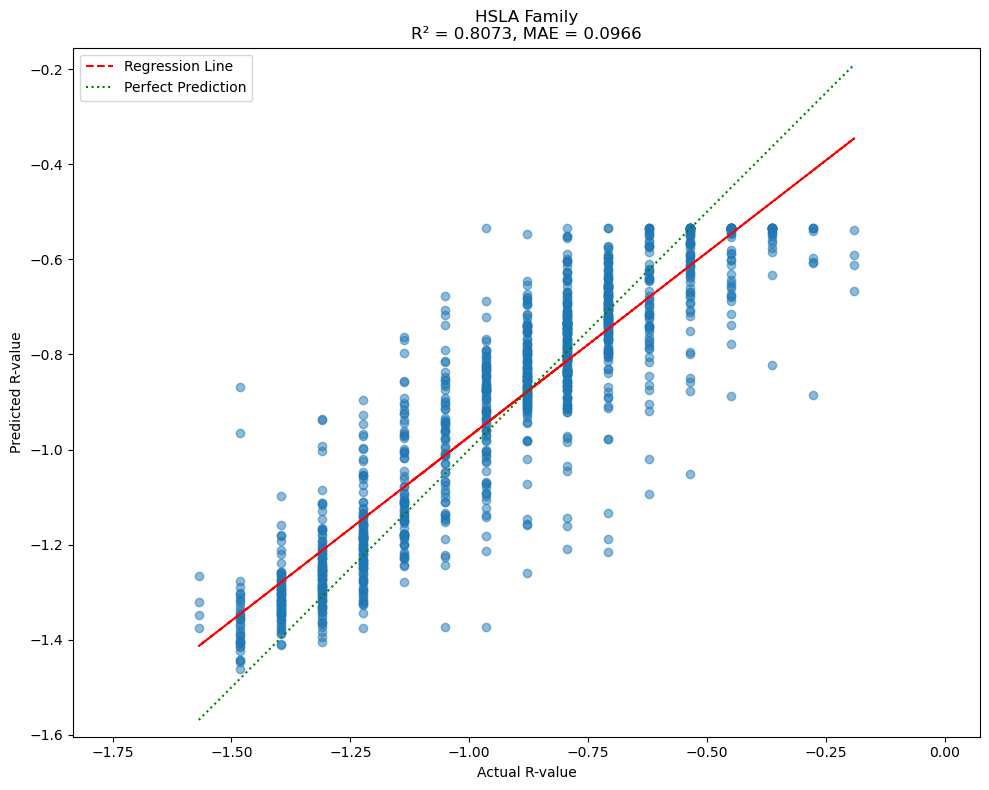

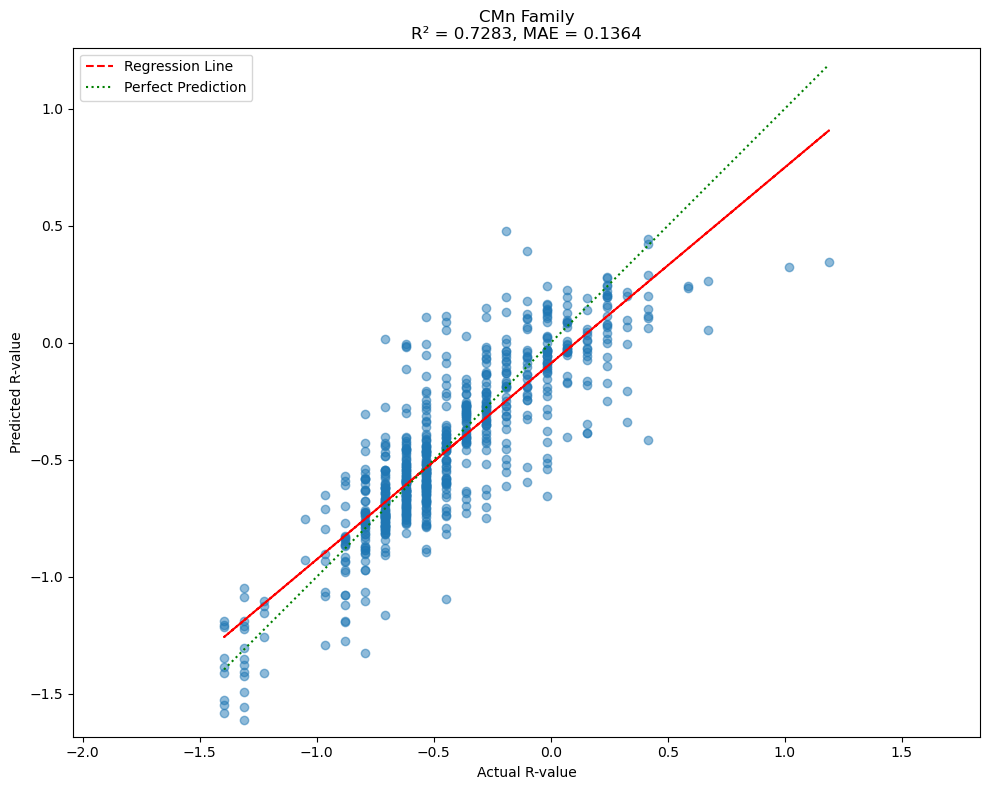

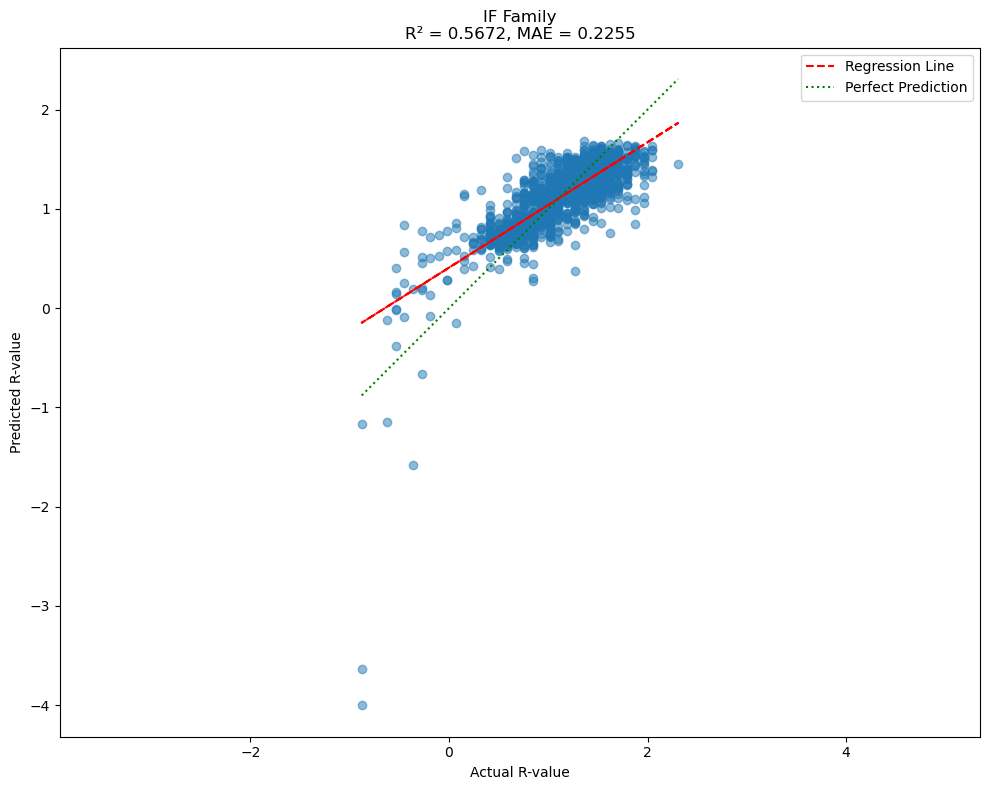

In [13]:
plot_actual_vs_predicted(test_scaled_df, family_models, features_dict)

In [14]:
eval

{'CMn': {'test_loss': 0.14518781006336212,
  'r2_score': 0.666689567967289,
  'Mean Absolute Error': 0.1451878045394243},
 'IF': {'test_loss': 0.21261371672153473,
  'r2_score': 0.6163104290607746,
  'Mean Absolute Error': 0.21261374851644022},
 'HSLA': {'test_loss': 0.0963527038693428,
  'r2_score': 0.7850923563117714,
  'Mean Absolute Error': 0.09635270031377992}}

In [15]:
df = process_steel_data(full_path, path, correlation_rate, 1, model_output=False)

Dropped 24 columns


/opt/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [16]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(['steel_family', 'steel_grade'], axis=1))
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
train_scaled_df['steel_family'] = train_df['steel_family'].reset_index(drop=True)

test_scaled = scaler.transform(test_df.drop(['steel_family', 'steel_grade'], axis=1))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
test_scaled_df['steel_family'] = test_df['steel_family'].reset_index(drop=True)

In [17]:
family_models, eval_no_model = train_family_models(train_scaled_df, features_dict, 100, best_params)

Epoch [10/100], Loss: 0.1898
Epoch [20/100], Loss: 0.1761
Epoch [30/100], Loss: 0.1711
Epoch [40/100], Loss: 0.1610
Epoch [50/100], Loss: 0.1594
Epoch [60/100], Loss: 0.1566
Epoch [70/100], Loss: 0.1560
Epoch [80/100], Loss: 0.1510
Epoch [90/100], Loss: 0.1461
Epoch [100/100], Loss: 0.1500
Evaluation for CMn - Test Loss: 0.1659, R2: 0.5633
Epoch [10/100], Loss: 0.2644
Epoch [20/100], Loss: 0.2447
Epoch [30/100], Loss: 0.2393
Epoch [40/100], Loss: 0.2365
Epoch [50/100], Loss: 0.2321
Epoch [60/100], Loss: 0.2303
Epoch [70/100], Loss: 0.2265
Epoch [80/100], Loss: 0.2236
Epoch [90/100], Loss: 0.2183
Epoch [100/100], Loss: 0.2146
Evaluation for IF - Test Loss: 0.2452, R2: 0.4868
Epoch [10/100], Loss: 0.1633
Epoch [20/100], Loss: 0.1410
Epoch [30/100], Loss: 0.1298
Epoch [40/100], Loss: 0.1255
Epoch [50/100], Loss: 0.1233
Epoch [60/100], Loss: 0.1203
Epoch [70/100], Loss: 0.1154
Epoch [80/100], Loss: 0.1141
Epoch [90/100], Loss: 0.1121
Epoch [100/100], Loss: 0.1107
Evaluation for HSLA - Test

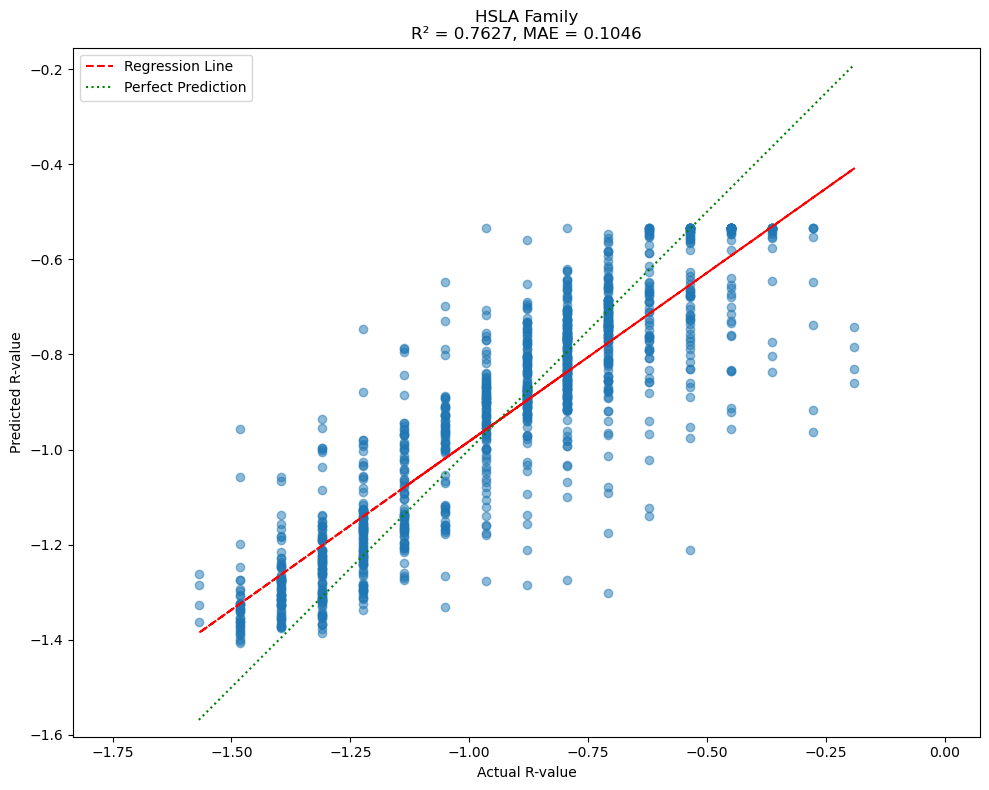

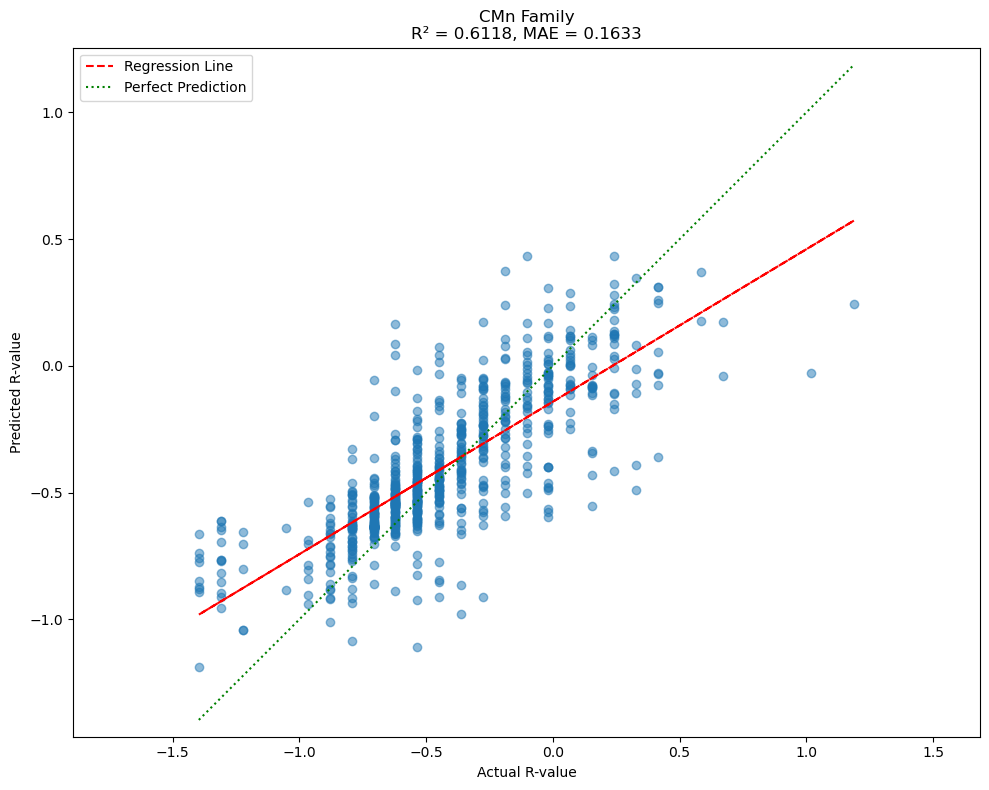

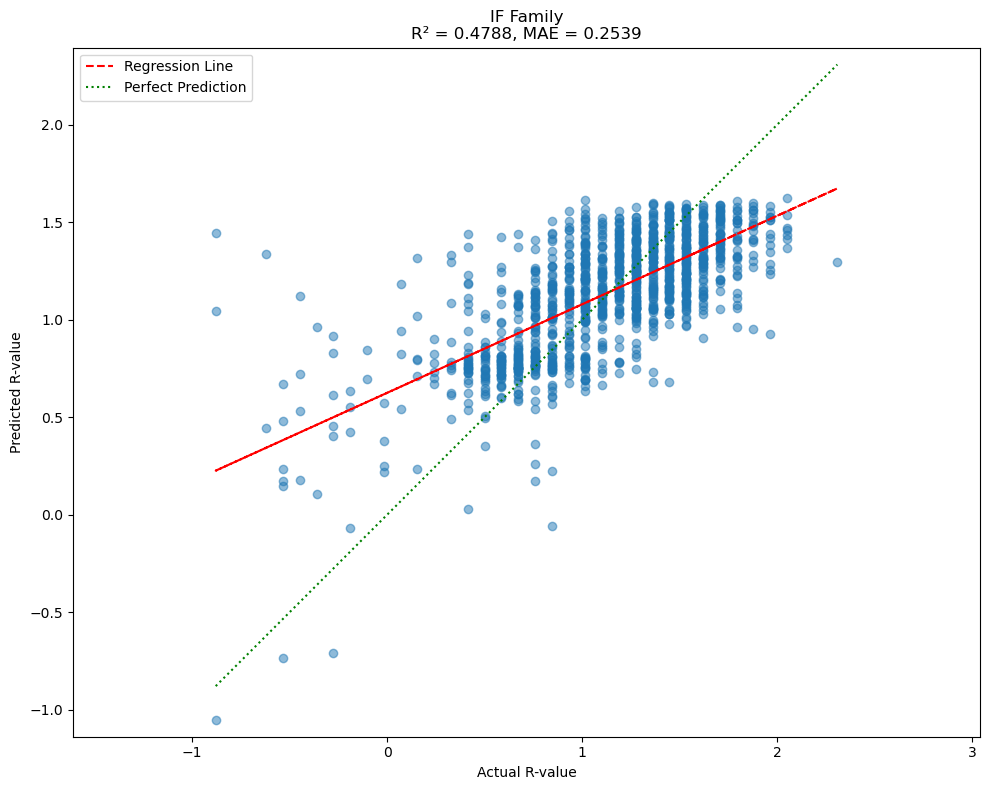

In [18]:
plot_actual_vs_predicted(test_scaled_df, family_models, features_dict)

In [19]:
eval_no_model

{'CMn': {'test_loss': 0.16594095528125763,
  'r2_score': 0.5632639235130181,
  'Mean Absolute Error': 0.1659409553171111},
 'IF': {'test_loss': 0.24518251419067383,
  'r2_score': 0.4867763306032208,
  'Mean Absolute Error': 0.24518250084859775},
 'HSLA': {'test_loss': 0.10727192461490631,
  'r2_score': 0.7333254146772591,
  'Mean Absolute Error': 0.10727192108615645}}

In [23]:
all_models = {'common layer': eval, 'common_no_model_output': eval_no_model}
data = []
for model, metrics in all_models.items():
    for category, values in metrics.items():
        data.append({
            'Model': model,
            'Steel family': category,
            'r2_score': values['r2_score'],
            'Mean Absolute Error': values['Mean Absolute Error']
        })
df = pd.DataFrame(data)
df

,Model,Steel family,r2_score,Mean Absolute Error
0,common layer,CMn,0.666690,0.145188
1,common layer,IF,0.616310,0.212614
2,common layer,HSLA,0.785092,0.096353
3,common_no_model_output,CMn,0.563264,0.165941
4,common_no_model_output,IF,0.486776,0.245183
5,common_no_model_output,HSLA,0.733325,0.107272


In [25]:
df.to_csv('results_mlp_common_layer.csv', index=False) 